In [ ]:
# Quick Swin-UNETR Inference Test Notebook
# Run this in a Jupyter notebook or Python script

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zarr
from omegaconf import DictConfig, OmegaConf
from hydra.utils import instantiate

# ============================================================================
# 1. SETUP PATHS
# ============================================================================
CHECKPOINT_DIR = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/test_swin_unetr_reproducibility/checkpoints/latest_model")
CHECKPOINT_FILE = CHECKPOINT_DIR / "zero_pp_rank_0_mp_rank_00_model_states.pt"

# Path to a test zarr file (you'll need to point this to an actual test sample)
# Example: from your database or a saved test sample
TEST_ZARR_PATH = None  # Set this to a path like "/path/to/test_sample.zarr"


In [ ]:

# ============================================================================
# 2. LOAD MODEL CONFIG AND INSTANTIATE MODEL
# ============================================================================
# Load the model config
model_cfg = OmegaConf.create({
    "_target_": "cell_observatory_finetune.models.meta_arch.swin_unetr.FinetuneSwinUNETR",
    "input_fmt": "ZYXC",
    "input_shape": [128, 128, 128, 2],
    "patch_shape": [2, 2, 2, None],
    "model_template": "swin-unetr-base",
    "task": "boundary_segmentation",
    "output_channels": 1,
})

model = instantiate(model_cfg)
model.eval()


In [ ]:

# ============================================================================
# 3. LOAD CHECKPOINT
# ============================================================================
print(f"Loading checkpoint from: {CHECKPOINT_FILE}")
checkpoint = torch.load(CHECKPOINT_FILE, map_location="cpu")

# Extract state dict (handle different checkpoint formats)
state_dict = None
for key in ["module", "state_dict", "model", "model_state_dict"]:
    if key in checkpoint and isinstance(checkpoint[key], dict):
        state_dict = checkpoint[key]
        break

if state_dict is None:
    # Try direct dict
    state_dict = checkpoint

# Load into model (handle DeepSpeed wrapper if present)
model_module = model.module if hasattr(model, "module") else model
missing, unexpected = model_module.load_state_dict(state_dict, strict=False)
print(f"Missing keys: {len(missing)}")
print(f"Unexpected keys: {len(unexpected)}")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model loaded on {device}")


In [ ]:

# ============================================================================
# 4. LOAD TEST DATA
# ============================================================================
# Option A: Load from zarr file directly
if TEST_ZARR_PATH and Path(TEST_ZARR_PATH).exists():
    zarr_group = zarr.open(TEST_ZARR_PATH, mode='r')
    # Assuming data is in '0' or similar key
    data_key = '0' if '0' in zarr_group else list(zarr_group.keys())[0]
    data = zarr_group[data_key][:]  # Shape: (Z, Y, X, C) or similar
    print(f"Loaded data shape: {data.shape}")
else:
    # Option B: Create dummy test data
    print("Creating dummy test data (128, 128, 128, 2)")
    data = np.random.randn(128, 128, 128, 2).astype(np.float16)
    # Normalize to reasonable range
    data = (data - data.min()) / (data.max() - data.min()) * 255
    data = data.astype(np.uint16)

# Ensure data is in ZYXC format
if data.ndim == 4 and data.shape[-1] == 2:
    # Already ZYXC
    pass
else:
    raise ValueError(f"Unexpected data shape: {data.shape}, expected (Z, Y, X, C)")


In [ ]:

# ============================================================================
# 5. PREPROCESSING
# ============================================================================
# Simple preprocessing (matching swin_unetr_preprocessor.yaml)
# For inference, we skip augmentation transforms

# Convert to torch tensor
data_tensor = torch.from_numpy(data).float()  # (Z, Y, X, C)

# Normalize (simple min-max normalization per channel)
for c in range(data_tensor.shape[-1]):
    channel = data_tensor[..., c]
    channel_min, channel_max = channel.min(), channel.max()
    if channel_max > channel_min:
        data_tensor[..., c] = (channel - channel_min) / (channel_max - channel_min)

# Add batch dimension: (1, Z, Y, X, C)
data_tensor = data_tensor.unsqueeze(0)

# Move to device
data_tensor = data_tensor.to(device)

# Create data_sample dict (format expected by model)
data_sample = {
    'data_tensor': data_tensor,
    'metainfo': {}
}

print(f"Preprocessed data shape: {data_tensor.shape}")


In [ ]:

# ============================================================================
# 6. RUN INFERENCE
# ============================================================================
print("Running inference...")
with torch.no_grad():
    # Model expects data_sample dict
    output = model.predict(data_sample)  # or model.forward(data_sample)

# Output shape depends on model - typically (B, C, Z, Y, X) or (B, Z, Y, X, C)
print(f"Output shape: {output.shape}")

# Convert to numpy for visualization
if isinstance(output, torch.Tensor):
    output_np = output.cpu().numpy()
else:
    output_np = output

# Remove batch dimension if present
if output_np.ndim == 5:
    output_np = output_np[0]  # (C, Z, Y, X) or (Z, Y, X, C)


In [ ]:

# ============================================================================
# 7. VISUALIZE
# ============================================================================
# Determine channel dimension
if output_np.shape[0] < 10:  # Likely (C, Z, Y, X)
    C, Z, Y, X = output_np.shape
    z_mid = Z // 2
    boundary_pred = output_np[0, z_mid] if C >= 1 else output_np[0, z_mid]
    if C >= 2:
        cell_pred = output_np[1, z_mid]
    else:
        cell_pred = None
elif output_np.shape[-1] < 10:  # Likely (Z, Y, X, C)
    Z, Y, X, C = output_np.shape
    z_mid = Z // 2
    boundary_pred = output_np[z_mid, ..., 0] if C >= 1 else output_np[z_mid]
    if C >= 2:
        cell_pred = output_np[z_mid, ..., 1]
    else:
        cell_pred = None
else:  # Assume (Z, Y, X) single channel
    Z, Y, X = output_np.shape
    z_mid = Z // 2
    boundary_pred = output_np[z_mid]
    cell_pred = None

# Visualize
fig, axes = plt.subplots(1, 3 if cell_pred is not None else 2, figsize=(15, 5))

# Input (middle slice, first channel)
input_slice = data_tensor[0, z_mid, :, :, 0].cpu().numpy()
axes[0].imshow(input_slice, cmap='gray')
axes[0].set_title('Input (Z={})'.format(z_mid))
axes[0].axis('off')

# Boundary prediction
axes[1].imshow(boundary_pred, cmap='hot')
axes[1].set_title('Boundary Prediction')
axes[1].axis('off')

# Cell prediction (if available)
if cell_pred is not None:
    axes[2].imshow(cell_pred, cmap='viridis')
    axes[2].set_title('Cell Prediction')
    axes[2].axis('off')

plt.tight_layout()
plt.savefig('swin_unetr_test_prediction.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to: swin_unetr_test_prediction.png")

In [4]:
# Load tiff file
from tifffile import imread
from pathlib import Path
tiff_path = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/test_inference_swin_unetr/inference/pred_inference_roi166_000x_000y_000z_predictions.tiff")
tiff_data = imread(tiff_path)

# Convert to numpy
tiff_data.shape


(1, 128, 896, 1536)

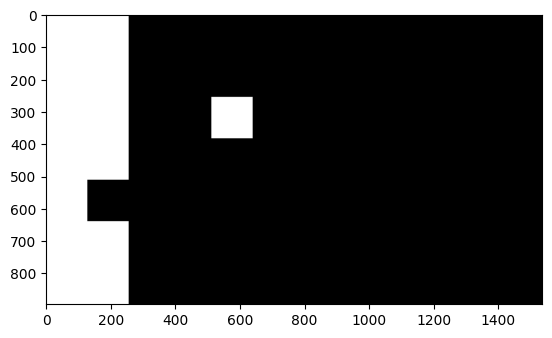

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Plot max projection, renorm all values via softmax
sm = np.exp(tiff_data[0])
sm = sm / sm.sum()
plt.imshow(sm[64, :, :], cmap="gray")
plt.show()



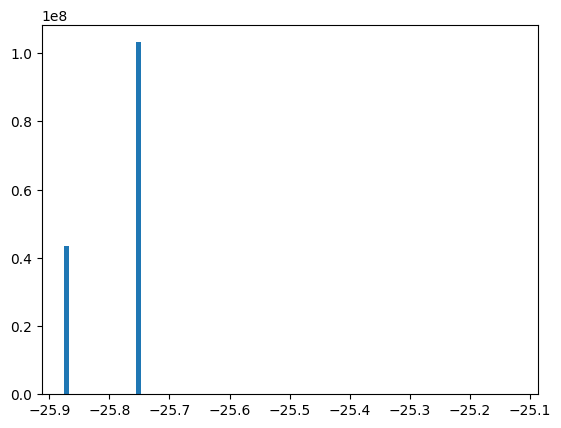

In [18]:
# plot pixel intensity histogram where values are >0
data = tiff_data[0].flatten()
new_data = data[data < 0]
plt.hist(new_data, bins=100)
plt.show()

In [17]:
new_data

array([], dtype=float32)

In [23]:
sm

array([[[3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.5318967e-19, 2.5318967e-19, 3.6838879e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         1.9718428e-19, 1.9718428e-19, 2.5318967e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         1.9718428e-19, 2.2343909e-19, 2.5318967e-19],
        ...,
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.2343909e-19, 2.2343909e-19, 2.5318967e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.2343909e-19, 2.2343909e-19, 2.5318967e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.5318967e-19, 2.5318967e-19, 3.2510196e-19]],

       [[3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.2343909e-19, 2.2343909e-19, 2.5318967e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         1.9718428e-19, 2.2343909e-19, 2.2343909e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.234

In [1]:
# Convert script: convert_tiff_to_32bit.py
import tifffile
from pathlib import Path

def convert_tiff_to_32bit(input_path, output_path):
    """Convert 64-bit TIFF to 32-bit float."""
    img = tifffile.imread(input_path)
    # Convert to float32
    img_32bit = img.astype('float32')
    tifffile.imwrite(output_path, img_32bit, compression='zlib')

# Convert all files
images_dir = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared/images")
labels_dir = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared/labels")
output_images = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared_32bit/images")
output_labels = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared_32bit/labels")
output_images.mkdir(parents=True, exist_ok=True)
output_labels.mkdir(parents=True, exist_ok=True)

for img_file in images_dir.glob("*.tif"):
    convert_tiff_to_32bit(img_file, output_images / img_file.name)

for lab_file in labels_dir.glob("*.tif"):
    convert_tiff_to_32bit(lab_file, output_labels / lab_file.name)

In [ ]:
# Load tiff file
from tifffile import imread
from pathlib import Path
# tiff_path = Path("/clusterfs/nvme/segment_3d/tests/outputs/inference_results/c3image_SwinUNetR_pred_3_2025_11_28_17_40_31.tif")
tiff_path = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_combined_datasets/base_model/SwinUNetR_Mlp_LeakyReLU_best_metric/mesoSPIM_C5_image_SwinUNetR_Mlp_LeakyReLU_pred_1_2025_12_05_14_20_26.tif")
tiff_path = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_combined_datasets/base_model/SwinUNetR_Mlp_LeakyReLU_best_metric/mesoSPIM_C5_image_SwinUNetR_Mlp_LeakyReLU_pred_1_2025_12_05_14_20_26.tif")
tiff_data = imread(tiff_path)
# Convert to numpy
tiff_data.shape

(249, 86, 94)

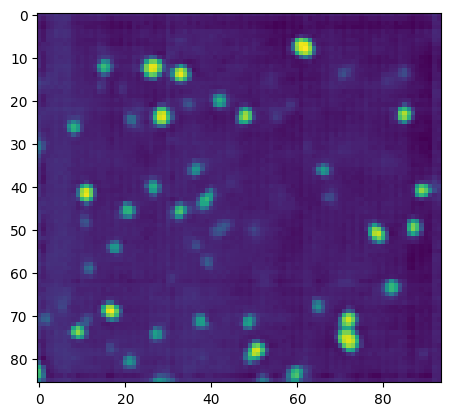

In [ ]:
import matplotlib.pyplot as plt

    

plt.imshow(tiff_data[100])
plt.show()


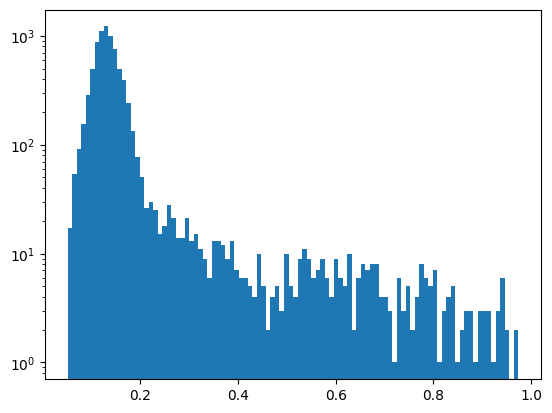

In [5]:
plt.hist(tiff_data[100].flatten(), bins=100, log=True)
plt.show()

c5image_SwinUNetR_SwiGLU_LeakyReLU_pred_1_2025_12_05_15_33_06.tif
249 86 94
124 86 94


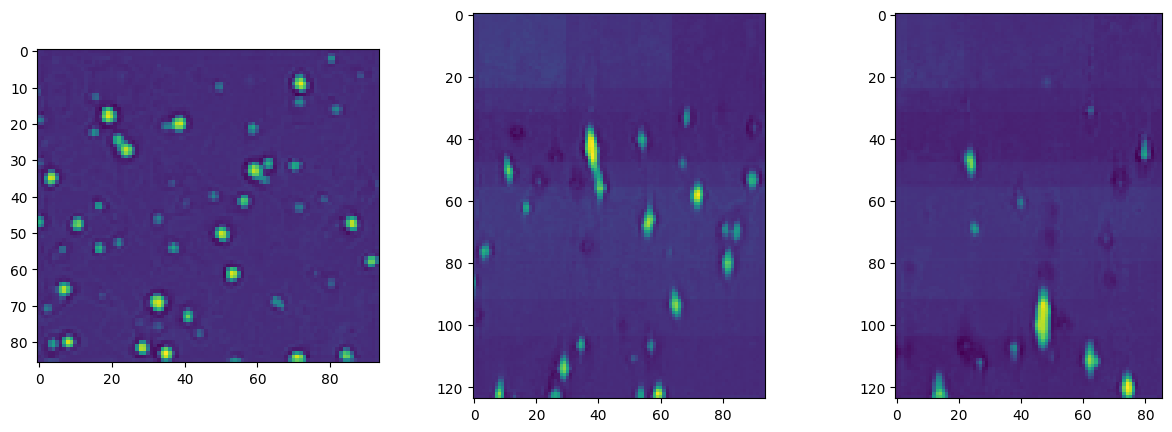

c5image_SwinUNetR_Mlp_ReLUSquared_pred_1_2025_12_05_15_32_52.tif
249 86 94
124 86 94


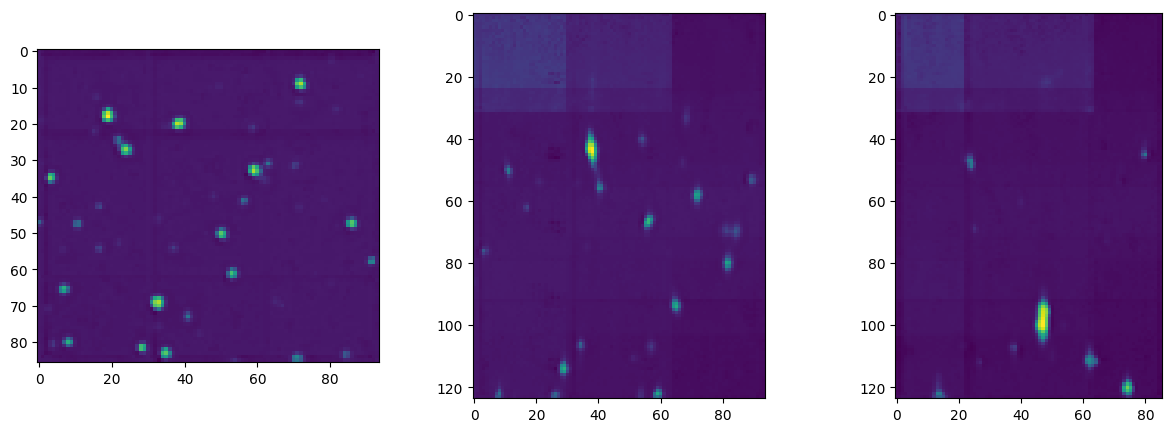

c5image_SwinUNetR_SwiGLU_ReLUSquared_pred_1_2025_12_05_15_33_20.tif
249 86 94
124 86 94


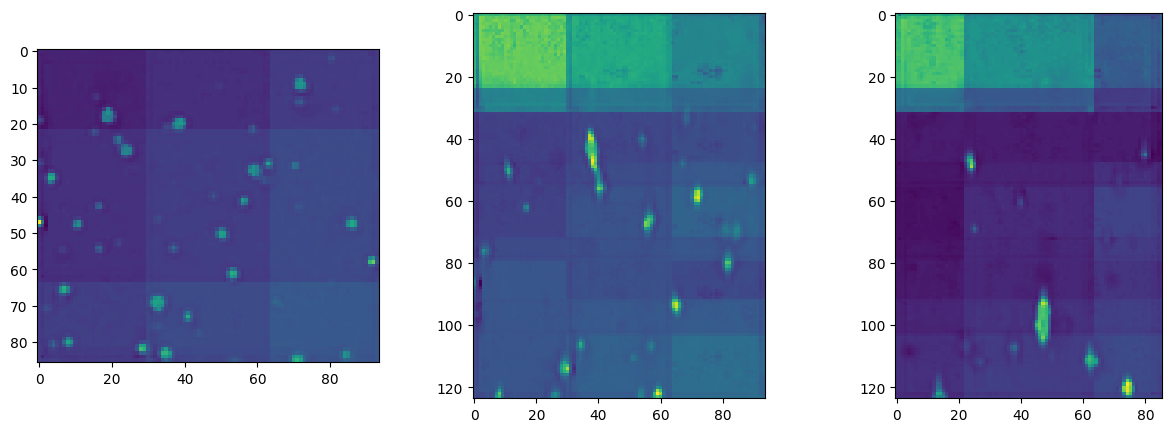

c5image_SwinUNetR_Mlp_LeakyReLU_pred_1_2025_12_05_15_32_38.tif
249 86 94
124 86 94


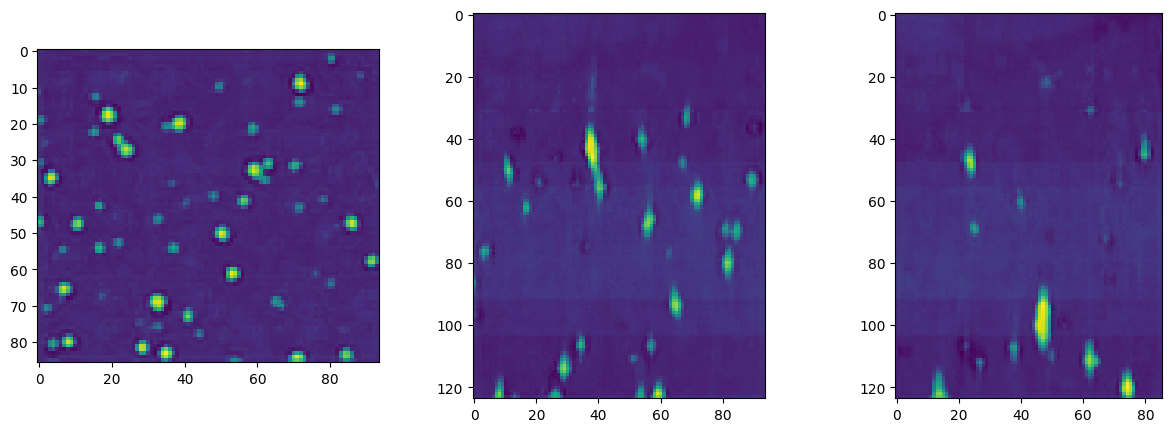

In [19]:
from tifffile import imread
from pathlib import Path
from skimage.transform import resize
import matplotlib.pyplot as plt

root_dir = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_combined_datasets/base_model")
root_dir = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_combined_datasets/val")
root_dir = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared_32bit")
root_dir = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_mesoSPIM/base_model")

downsample_factor = (0.5, 1, 1)

for checkpoint_dir in root_dir.iterdir():
    if not checkpoint_dir.is_dir():
        continue
    for tiff_file in checkpoint_dir.glob("*.tif"):
        print(tiff_file.name)
        tiff_data = imread(tiff_file)
        
        # Convert to numpy
        Z, Y, X = tiff_data.shape
        print(Z, Y, X)
        Z = int(Z*downsample_factor[0])
        Y = int(Y*downsample_factor[1])
        X = int(X*downsample_factor[2])
        print(Z, Y, X)
            
        
        # Resize
        tiff_data = resize(tiff_data, (Z, Y, X), order=1, preserve_range=True)
        
        # Orhoslice subplots 
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(tiff_data[Z//2, :, :])
        axes[1].imshow(tiff_data[:, Y//2, :])
        axes[2].imshow(tiff_data[:, :, X//2])
        plt.show()

In [7]:
root_dir = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_combined_datasets/base_model")

for checkpoint_dir in root_dir.iterdir():
    if not checkpoint_dir.is_dir():
        continue
    print(checkpoint_dir)


/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_combined_datasets/base_model/SwinUNetR_Mlp_LeakyReLU_best_metric
/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_combined_datasets/base_model/SwinUNetR_SwiGLU_LeakyReLU_best_metric
/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_combined_datasets/base_model/SwinUNetR_SwiGLU_ReLUSquared_best_metric
/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_combined_datasets/base_model/SwinUNetR_Mlp_ReLUSquared_best_metric


In [13]:
# Running F1 score vs threshold
import numpy as np
from sklearn.metrics import f1_score
from tifffile import imread
from pathlib import Path

# Load predictions and labels
predictions = imread("/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_mesoSPIM/base_model/SwinUNetR_SwiGLU_ReLUSquared_best_metric/c5image_SwinUNetR_SwiGLU_ReLUSquared_pred_1_2025_12_05_15_33_20.tif")
labels = imread("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/val/labels/c5label.tif")
semantic_labels = labels > 0
# Calculate F1 score for each threshold
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for threshold in thresholds:
    # Apply threshold to predictions
    binary_predictions = (predictions > threshold).astype(np.uint8)
    
    # Calculate F1 score
    f1 = f1_score(semantic_labels.flatten(), binary_predictions.flatten())
    f1_scores.append(f1)



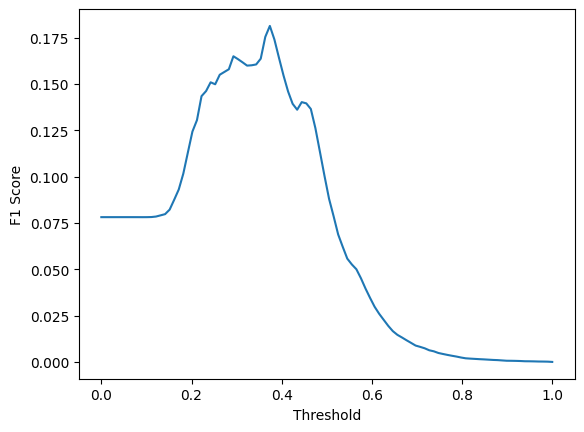

Best threshold: 0.37373737373737376


In [14]:
# Plot F1 score vs threshold
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.show()

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold: {best_threshold}")



c5image_SwinUNetR_SwiGLU_ReLUSquared_pred_1_2025_12_05_17_36_50.tif


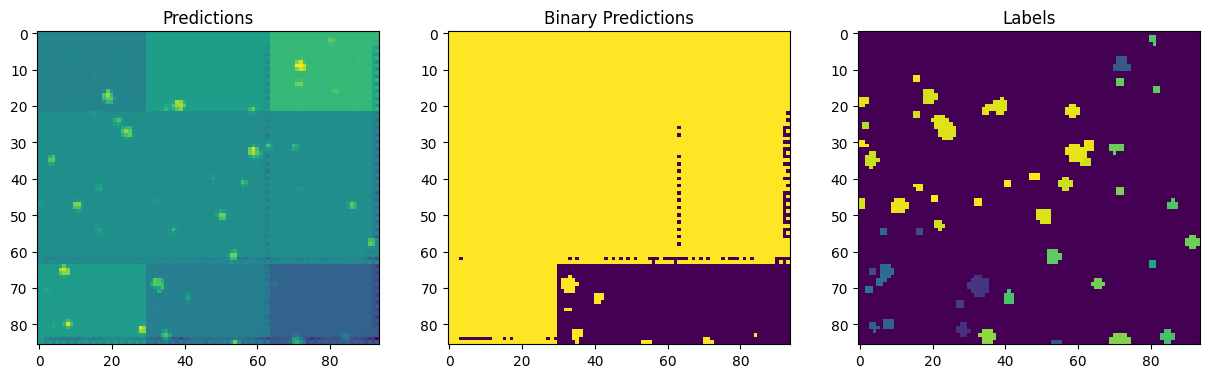

c5image_SwinUNetR_SwiGLU_ReLUSquared_pred_1_2025_12_05_17_57_45.tif


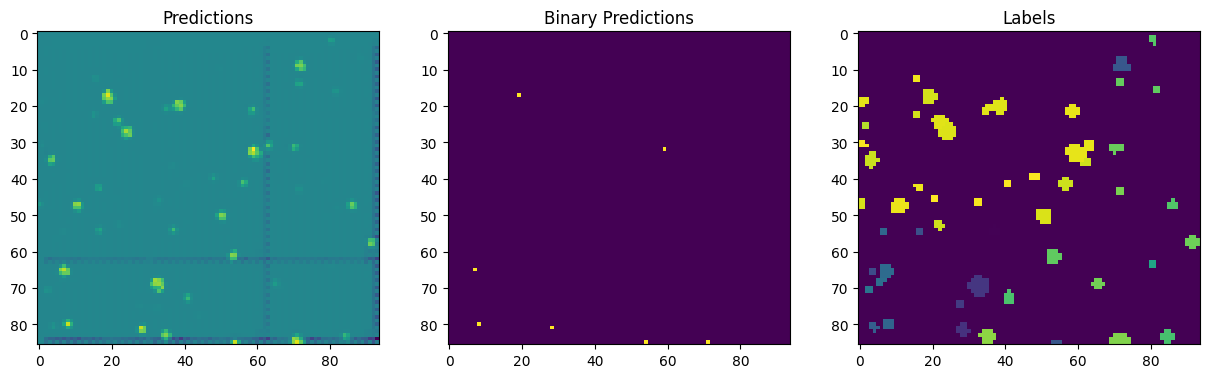

c5image_SwinUNetR_SwiGLU_ReLUSquared_pred_1_2025_12_06_15_53_14.tif


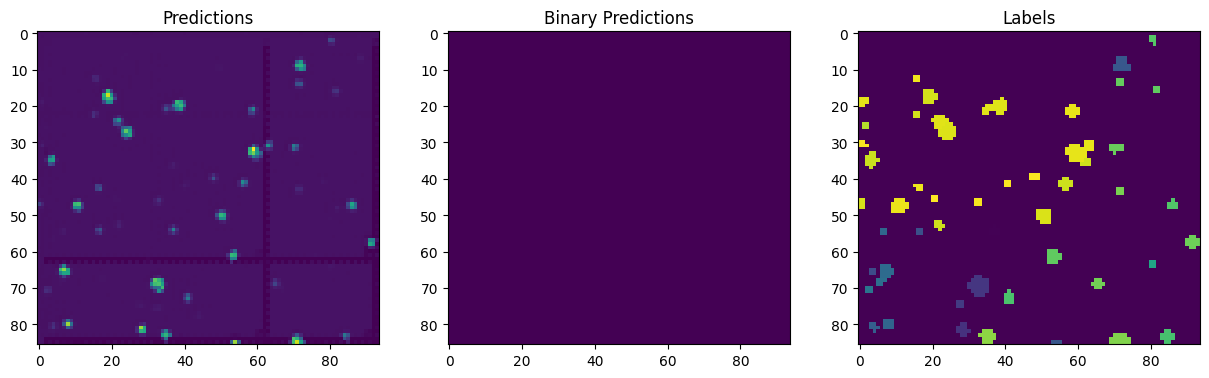

c5image_SwinUNetR_Mlp_ReLUSquared_pred_1_2025_12_06_15_52_32.tif


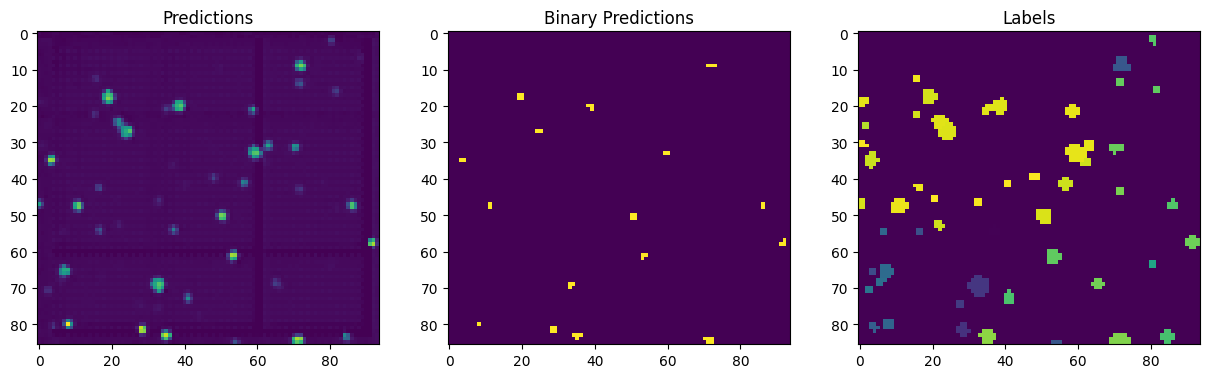

c5image_SwinUNetR_Mlp_ReLUSquared_pred_1_2025_12_05_17_36_23.tif


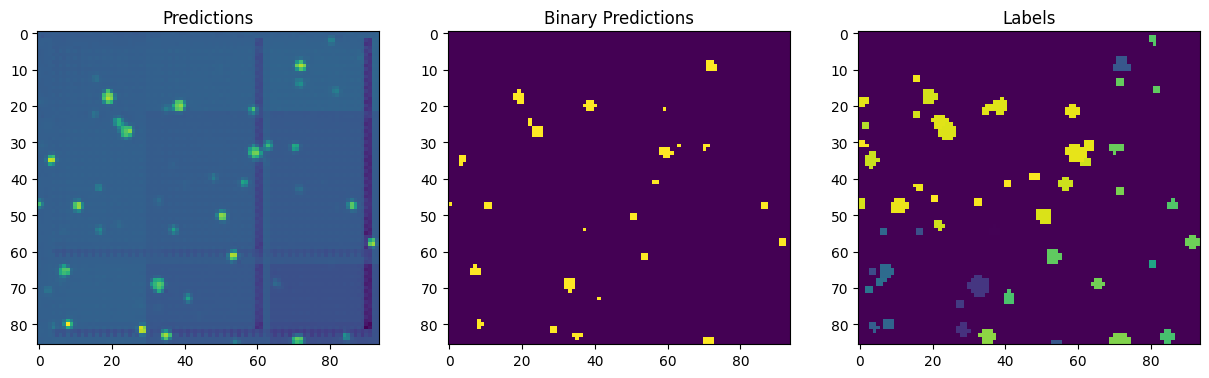

c5image_SwinUNetR_Mlp_ReLUSquared_pred_1_2025_12_05_17_57_19.tif


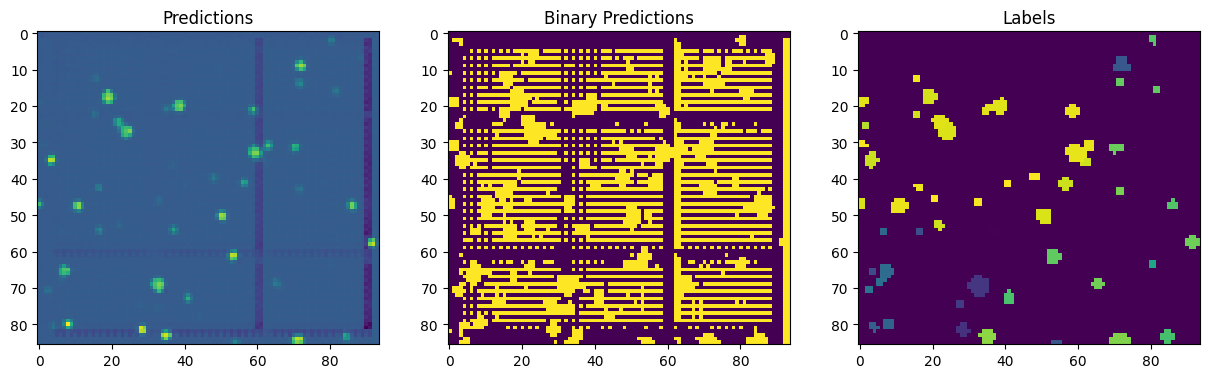

c5image_SwinUNetR_Mlp_LeakyReLU_pred_1_2025_12_05_17_36_10.tif


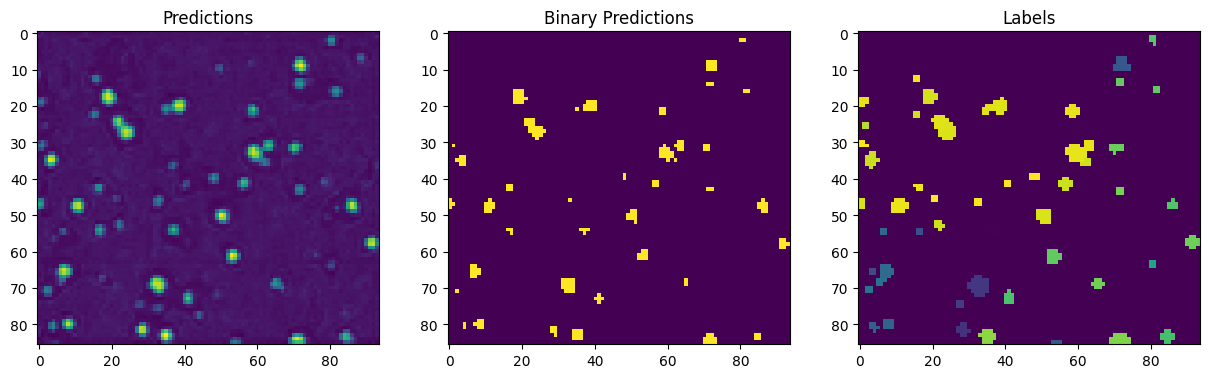

c5image_SwinUNetR_Mlp_LeakyReLU_pred_1_2025_12_06_16_20_00.tif


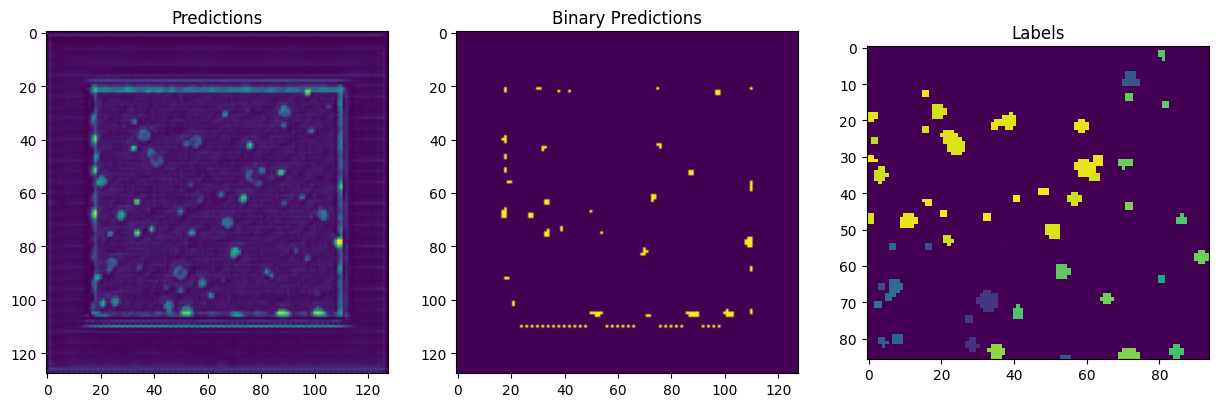

ValueError: operands could not be broadcast together with shapes (1814727,) (4222336,) 

In [12]:
# Running bootstrapped DICE score by subdividing volume into N^3 cubes and sampling N^3 times with replacement
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_multiotsu
from pathlib import Path

def compute_dice_score(binary_labels, binary_predictions, N):
    shape = binary_predictions.shape
    cube_shape = (shape[0] // N, shape[1] // N, shape[2] // N)  # Shape of each cube

    # Store the (z,y,x) cube start indices
    cubes = []
    for zi in range(N):
        for yi in range(N):
            for xi in range(N):
                z0 = zi * cube_shape[0]
                y0 = yi * cube_shape[1]
                x0 = xi * cube_shape[2]
                z1 = (zi + 1) * cube_shape[0] if zi < N - 1 else shape[0]
                y1 = (yi + 1) * cube_shape[1] if yi < N - 1 else shape[1]
                x1 = (xi + 1) * cube_shape[2] if xi < N - 1 else shape[2]
                cubes.append((slice(z0, z1), slice(y0, y1), slice(x0, x1)))

    num_cubes = len(cubes)
    dice_scores = []

    rng = np.random.default_rng(seed=42)

    # Bootstrap: for num_cubes times, sample cubes with replacement, concatenate, compute dice
    num_bootstraps = num_cubes  # As per instruction
    for i in range(num_bootstraps):
        sampled_cubes_idx = rng.choice(range(num_cubes), size=num_cubes, replace=True)
        sem_boot = []
        pred_boot = []
        for idx in sampled_cubes_idx:
            s = cubes[idx]
            sem_boot.append(binary_labels[s])
            pred_boot.append(binary_predictions[s])
        cube_semantic_labels = np.concatenate([x.flatten() for x in sem_boot])
        cube_binary_predictions = np.concatenate([x.flatten() for x in pred_boot])

        intersection = np.sum(np.logical_and(cube_semantic_labels, cube_binary_predictions))
        denom = np.sum(cube_semantic_labels) + np.sum(cube_binary_predictions)
        dice = 2 * intersection / denom if denom > 0 else np.nan
        dice_scores.append(dice)

    dice_scores = np.array(dice_scores)
    return dice_scores

# Specify N for N^3 cubes
N = 5  # Set N (e.g., 4 or 5 for 125 subvolumes, adjust for desired granularity)
threshold = 0.4

labels = imread("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/val/labels/c5label.tif")
binary_labels = labels > 0


experiment_dir = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/infer_swinunetr_cellseg3d_mesoSPIM/feature_size_12")
dice_by_model = {}
for checkpoint_dir in experiment_dir.iterdir():
    if not checkpoint_dir.is_dir():
        continue
    elif "best_metric" in checkpoint_dir.name:
        continue
    for tiff_file in checkpoint_dir.glob("*.tif"):
        # if "12_06" not in tiff_file.name:
        #     continue
        print(tiff_file.name)
        predictions = imread(tiff_file)
        # threshold = threshold_otsu(predictions)
        binary_predictions = predictions > threshold
        # plot central z slice of predictions and labels
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(predictions[predictions.shape[0]//2, :, :])
        plt.title("Predictions")
        plt.subplot(1, 3, 2)
        plt.imshow(binary_predictions[binary_predictions.shape[0]//2, :, :])
        plt.title("Binary Predictions")
        plt.subplot(1, 3, 3)
        plt.imshow(labels[labels.shape[0]//2, :, :])
        plt.title("Labels")
        plt.show()
        dice_scores = compute_dice_score(binary_labels, binary_predictions, N)
        dice_by_model[tiff_file.name] = dice_scores


In [7]:
import pandas as pd
df_scores = pd.DataFrame(dice_by_model)
df_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
c5image_SwinUNetR_SwiGLU_ReLUSquared_pred_1_2025_12_06_15_53_14.tif,125.0,0.422657,0.007152,0.402581,0.417331,0.422962,0.428626,0.438574
c5image_SwinUNetR_Mlp_ReLUSquared_pred_1_2025_12_06_15_52_32.tif,125.0,0.490666,0.006564,0.474935,0.486688,0.490714,0.495209,0.505246
c5image_SwinUNetR_Mlp_LeakyReLU_pred_1_2025_12_06_15_50_06.tif,125.0,0.821462,0.005177,0.807591,0.817978,0.821746,0.824835,0.833414
c5image_SwinUNetR_Mlp_LeakyReLU_pred_1_2025_12_06_15_52_10.tif,125.0,0.821462,0.005177,0.807591,0.817978,0.821746,0.824835,0.833414
c5image_SwinUNetR_SwiGLU_LeakyReLU_pred_1_2025_12_06_15_52_53.tif,125.0,0.765586,0.007017,0.747985,0.761079,0.766293,0.769819,0.782855


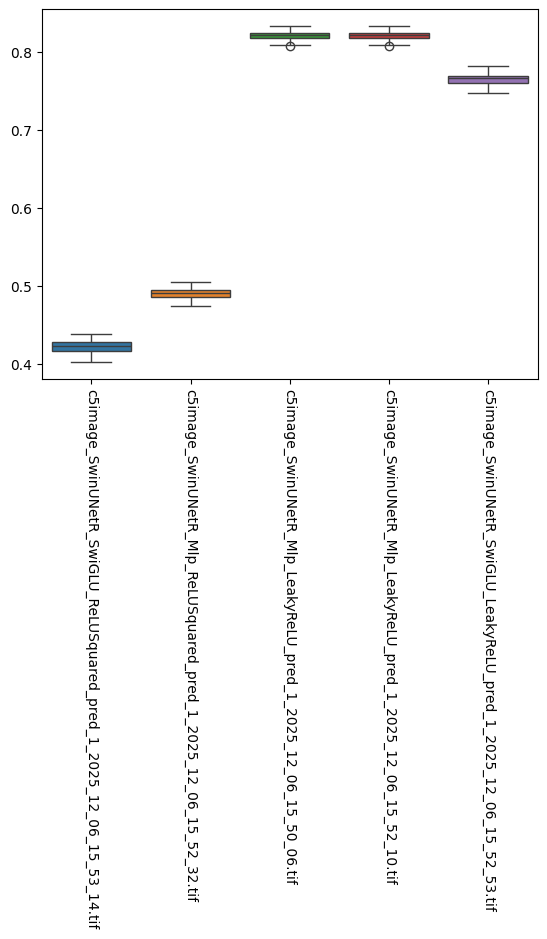

Bootstrapped DICE: mean = 0.7656, std = 0.0070


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of bootstrapped dice scores
sns.boxplot(data=df_scores)
# Rotate x-axis labels
plt.xticks(rotation=270)
plt.show()
print(f"Bootstrapped DICE: mean = {np.nanmean(dice_scores):.4f}, std = {np.nanstd(dice_scores):.4f}")

In [80]:
df = pd.read_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/gendice_val.csv", index_col=0).reset_index()
df

,Name,_wandb,Validation/Batch Loss
0,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,NaN,0.174340
1,model_name_SwinUNetR_Mlp_ReLUSquared_training_...,NaN,0.168078
2,model_name_SwinUNetR_SwiGLU_LeakyReLU_training...,NaN,0.157331
3,model_name_SwinUNetR_Mlp_LeakyReLU_training_ty...,NaN,0.150507
4,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,NaN,0.212150
5,model_name_SwinUNetR_Mlp_ReLUSquared_training_...,NaN,0.159337
6,model_name_SwinUNetR_SwiGLU_LeakyReLU_training...,NaN,0.180310
7,model_name_SwinUNetR_Mlp_LeakyReLU_training_ty...,NaN,0.153611
8,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,NaN,0.692317
9,model_name_SwinUNetR_Mlp_ReLUSquared_training_...,NaN,0.276498


In [160]:
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_multiotsu
from pathlib import Path

df = pd.read_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/gendice_val.csv", index_col=0).reset_index()
import re
import ast

def extract_fields(s):
    # model name
    name_match = re.search(r"model_name_([A-Za-z0-9]+)_([A-Za-z0-9]+)_([A-Za-z0-9]+)", s)
    model = name_match.group(1) if name_match else None
    mlp = name_match.group(2) if name_match else None
    activation = name_match.group(3) if name_match else None
    

    # feature size (expects: feature_size_someval)
    feature_match = re.search(r"feature_size_([A-Za-z0-9]+)", s)
    feature_size = feature_match.group(1) if feature_match else None

    # depths (expects: depths_\[.*?\] or depths_\([\d,\s]+\))
    depths_match = re.search(r"depths_\[([^\]]+)\]", s)
    if depths_match:
        try:
            depths = ast.literal_eval("[" + depths_match.group(1) + "]")  # Convert string list to actual list
        except Exception:
            depths = None
    else:
        depths = None

    # Extract date ("12_06") and time ("17_48") from ...training_time_2025_12_06_17_48_17...
    datetime_match = re.search(
        r"training_time_(\d{4})_(\d{2})_(\d{2})_(\d{2})_(\d{2})_(\d{2})", s
    )
    if datetime_match:
        date_str = f"{datetime_match.group(2)}_{datetime_match.group(3)}"
        time_str = f"{datetime_match.group(4)}_{datetime_match.group(5)}"
    else:
        date_str = None
        time_str = None

    # Extract the loss type after the first "-" or " - "
    # and remove __MIN or any trailing stuff, keep only core loss type (e.g., Batch Loss)
    # Supports: "- Validation/Batch Loss__MIN", "- Batch Loss"
    loss_type_full = None
    loss_type_core = None
    loss_type_match = re.search(r"-\s*([A-Za-z/ ]*Loss)(?:__MIN)?", s)
    if loss_type_match:
        loss_type_full = loss_type_match.group(1).strip()
        # Just take last part if like "Validation/Batch Loss"
        loss_type_core = loss_type_full.split("/")[-1].strip()
    else:
        loss_type_core = None

    return pd.Series({
        'model': model, 
        'mlp': mlp,
        'activation': activation,
        'feature_size': feature_size, 
        'depths': depths,
        'date': date_str,
        'time': time_str,
        'loss_type': loss_type_core
    })

fields = df["Name"].apply(extract_fields)
fields["Generalized Dice"] = 1 - df["Validation/Batch Loss"]
fields["depths"] = fields["depths"].apply(lambda x: str(x))


In [161]:
fields
fields["Hidden size / Depth"] = fields["feature_size"] + " / " + fields["depths"]

In [162]:
fields.head()

,model,mlp,activation,feature_size,depths,date,time,loss_type,Generalized Dice,Hidden size / Depth
0,SwinUNetR,SwiGLU,ReLUSquared,base,"[1, 1, 1, 1]",12_06,17_49,None,0.825660,"base / [1, 1, 1, 1]"
1,SwinUNetR,Mlp,ReLUSquared,base,"[1, 1, 1, 1]",12_06,17_49,None,0.831922,"base / [1, 1, 1, 1]"
2,SwinUNetR,SwiGLU,LeakyReLU,base,"[1, 1, 1, 1]",12_06,17_49,None,0.842669,"base / [1, 1, 1, 1]"
3,SwinUNetR,Mlp,LeakyReLU,base,"[1, 1, 1, 1]",12_06,17_48,None,0.849493,"base / [1, 1, 1, 1]"
4,SwinUNetR,SwiGLU,ReLUSquared,base,"[2, 2, 2, 2]",12_06,17_39,None,0.787850,"base / [2, 2, 2, 2]"


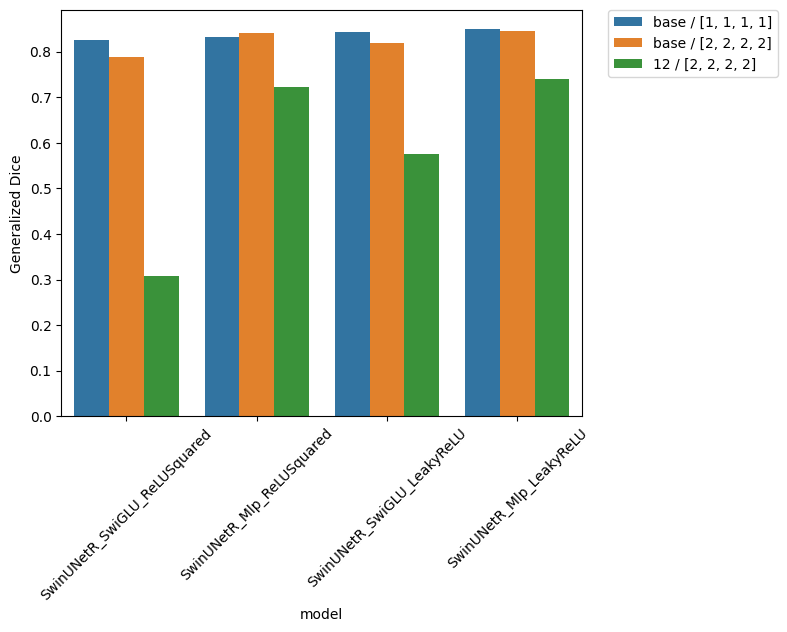

In [96]:
ax = sns.barplot(
    data=fields,  # [fields["depths"] == "[2, 2, 2, 2]"],
    x="model",
    y="Generalized Dice",
    hue="Hidden size / Depth",
    dodge=True
)
plt.tight_layout()
plt.xticks(rotation=45)
# Move the legend outside the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

,Name,_wandb,Validation/Batch Loss
0,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,NaN,0.174340
1,model_name_SwinUNetR_Mlp_ReLUSquared_training_...,NaN,0.168078
2,model_name_SwinUNetR_SwiGLU_LeakyReLU_training...,NaN,0.157331
3,model_name_SwinUNetR_Mlp_LeakyReLU_training_ty...,NaN,0.150507
4,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,NaN,0.212150
5,model_name_SwinUNetR_Mlp_ReLUSquared_training_...,NaN,0.159337
6,model_name_SwinUNetR_SwiGLU_LeakyReLU_training...,NaN,0.180310
7,model_name_SwinUNetR_Mlp_LeakyReLU_training_ty...,NaN,0.153611
8,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,NaN,0.692317
9,model_name_SwinUNetR_Mlp_ReLUSquared_training_...,NaN,0.276498


In [163]:
val_loss_df = pd.read_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/val_epoch_loss.csv", index_col=0).T.reset_index()
val_loss_df

Step,index,19,39,59,79,99,119,139,159,179,...,323,343,363,383,403,423,443,463,483,503
0,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,0.815386,0.797542,0.796681,0.790679,0.850216,0.778393,0.772401,0.751854,0.769651,...,0.707904,0.721764,0.727258,0.682127,0.703966,0.701740,0.708529,0.756161,0.686779,0.693389
1,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,0.815386,0.797542,0.796681,0.790679,0.850216,0.778393,0.772401,0.751854,0.769651,...,0.707904,0.721764,0.727258,0.682127,0.703966,0.701740,0.708529,0.756161,0.686779,0.693389
2,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,0.815386,0.797542,0.796681,0.790679,0.850216,0.778393,0.772401,0.751854,0.769651,...,0.707904,0.721764,0.727258,0.682127,0.703966,0.701740,0.708529,0.756161,0.686779,0.693389
3,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,0.858409,0.717773,0.464721,0.340628,0.218757,0.211621,0.181459,0.155519,0.227208,...,0.234368,0.150251,0.206348,0.180980,0.201428,0.177730,0.179212,0.139300,0.150594,0.185154
4,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,0.858409,0.717773,0.464721,0.340628,0.218757,0.211621,0.181459,0.155519,0.227208,...,0.234368,0.150251,0.206348,0.180980,0.201428,0.177730,0.179212,0.139300,0.150594,0.185154
5,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,0.858409,0.717773,0.464721,0.340628,0.218757,0.211621,0.181459,0.155519,0.227208,...,0.234368,0.150251,0.206348,0.180980,0.201428,0.177730,0.179212,0.139300,0.150594,0.185154
6,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,0.828530,0.754049,0.375365,0.241390,0.229742,0.210587,0.152744,0.229925,0.192315,...,0.158105,0.154213,0.165400,0.182380,0.214095,0.216133,0.198145,0.178031,0.193974,0.231911
7,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,0.828530,0.754049,0.375365,0.241390,0.229742,0.210587,0.152744,0.229925,0.192315,...,0.158105,0.154213,0.165400,0.182380,0.214095,0.216133,0.198145,0.178031,0.193974,0.231911
8,model_name_SwinUNetR_SwiGLU_ReLUSquared_traini...,0.828530,0.754049,0.375365,0.241390,0.229742,0.210587,0.152744,0.229925,0.192315,...,0.158105,0.154213,0.165400,0.182380,0.214095,0.216133,0.198145,0.178031,0.193974,0.231911
9,model_name_SwinUNetR_Mlp_ReLUSquared_training_...,0.836880,0.808541,0.770540,0.717701,0.718635,0.559555,0.471934,0.495184,0.476976,...,0.302803,0.301036,0.275383,0.310624,0.282846,0.294997,0.279276,0.297019,0.321886,0.295127


In [164]:
val_loss_fields = val_loss_df["index"].apply(extract_fields)
val_loss_fields["depths"] = val_loss_fields["depths"].apply(lambda x: str(x))
val_loss_fields

,model,mlp,activation,feature_size,depths,date,time,loss_type
0,SwinUNetR,SwiGLU,ReLUSquared,12,"[2, 2, 2, 2]",12_06,19_32,Mean Loss
1,SwinUNetR,SwiGLU,ReLUSquared,12,"[2, 2, 2, 2]",12_06,19_32,Mean Loss
2,SwinUNetR,SwiGLU,ReLUSquared,12,"[2, 2, 2, 2]",12_06,19_32,Mean Loss
3,SwinUNetR,SwiGLU,ReLUSquared,base,"[1, 1, 1, 1]",12_06,19_31,Mean Loss
4,SwinUNetR,SwiGLU,ReLUSquared,base,"[1, 1, 1, 1]",12_06,19_31,Mean Loss
5,SwinUNetR,SwiGLU,ReLUSquared,base,"[1, 1, 1, 1]",12_06,19_31,Mean Loss
6,SwinUNetR,SwiGLU,ReLUSquared,base,"[2, 2, 2, 2]",12_06,19_29,Mean Loss
7,SwinUNetR,SwiGLU,ReLUSquared,base,"[2, 2, 2, 2]",12_06,19_29,Mean Loss
8,SwinUNetR,SwiGLU,ReLUSquared,base,"[2, 2, 2, 2]",12_06,19_29,Mean Loss
9,SwinUNetR,Mlp,ReLUSquared,12,"[2, 2, 2, 2]",12_06,19_28,Mean Loss


In [165]:
val_loss_plot = val_loss_fields.merge(val_loss_df.drop(columns=["index"]), left_index=True, right_index=True)
val_loss_plot.head()

,model,mlp,activation,feature_size,depths,date,time,loss_type,19,39,...,323,343,363,383,403,423,443,463,483,503
0,SwinUNetR,SwiGLU,ReLUSquared,12,"[2, 2, 2, 2]",12_06,19_32,Mean Loss,0.815386,0.797542,...,0.707904,0.721764,0.727258,0.682127,0.703966,0.70174,0.708529,0.756161,0.686779,0.693389
1,SwinUNetR,SwiGLU,ReLUSquared,12,"[2, 2, 2, 2]",12_06,19_32,Mean Loss,0.815386,0.797542,...,0.707904,0.721764,0.727258,0.682127,0.703966,0.70174,0.708529,0.756161,0.686779,0.693389
2,SwinUNetR,SwiGLU,ReLUSquared,12,"[2, 2, 2, 2]",12_06,19_32,Mean Loss,0.815386,0.797542,...,0.707904,0.721764,0.727258,0.682127,0.703966,0.70174,0.708529,0.756161,0.686779,0.693389
3,SwinUNetR,SwiGLU,ReLUSquared,base,"[1, 1, 1, 1]",12_06,19_31,Mean Loss,0.858409,0.717773,...,0.234368,0.150251,0.206348,0.180980,0.201428,0.17773,0.179212,0.139300,0.150594,0.185154
4,SwinUNetR,SwiGLU,ReLUSquared,base,"[1, 1, 1, 1]",12_06,19_31,Mean Loss,0.858409,0.717773,...,0.234368,0.150251,0.206348,0.180980,0.201428,0.17773,0.179212,0.139300,0.150594,0.185154


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
val_loss_df = pd.read_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/val_epoch_loss.csv", index_col=0).T.reset_index()
val_loss_fields = val_loss_df["index"].apply(extract_fields)
val_loss_fields["depths"] = val_loss_fields["depths"].apply(lambda x: str(x))
val_loss_plot = val_loss_fields.merge(val_loss_df.drop(columns=["index"]), left_index=True, right_index=True)

# Identify step columns (numeric column names)
id_cols = ["model", "mlp", "activation", "feature_size", "depths", "date", "time", "loss_type"]
step_cols = [col for col in val_loss_plot.columns if col not in id_cols]

# Melt the dataframe from wide to long format
val_loss_long = pd.melt(
    val_loss_plot,
    id_vars=id_cols,
    value_vars=step_cols,
    var_name="step",
    value_name="loss"
)

# Convert step to numeric
val_loss_long["step"] = pd.to_numeric(val_loss_long["step"])
val_loss_long["epoch"] = val_loss_long["step"] // 10
val_loss_long["feature_size"] = val_loss_long["feature_size"].replace("base", "24")
# Remove duplicate rows (if any) by taking unique combinations
val_loss_long = val_loss_long.drop_duplicates(subset=id_cols + ["step"])



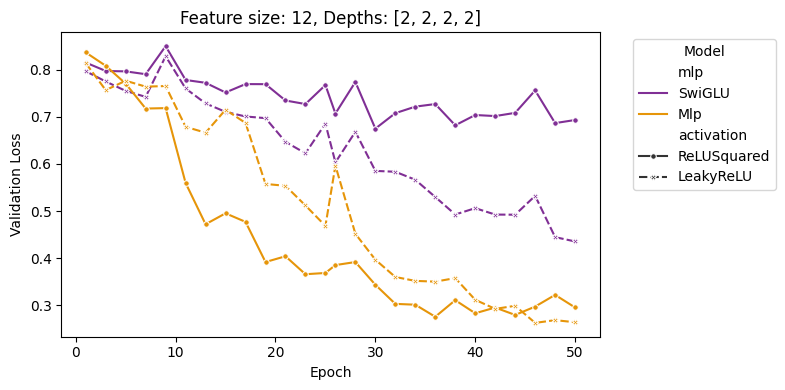

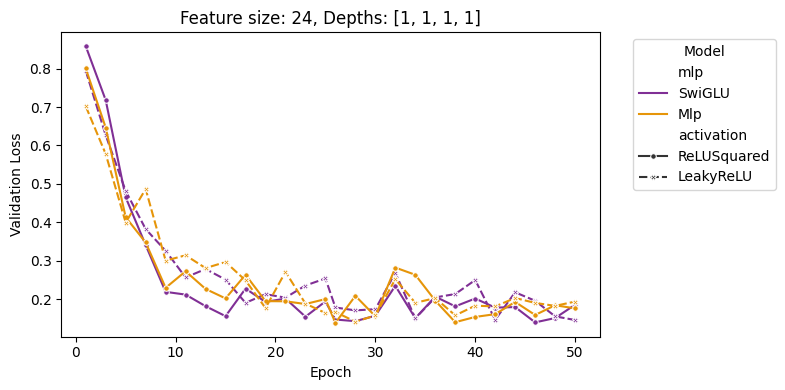

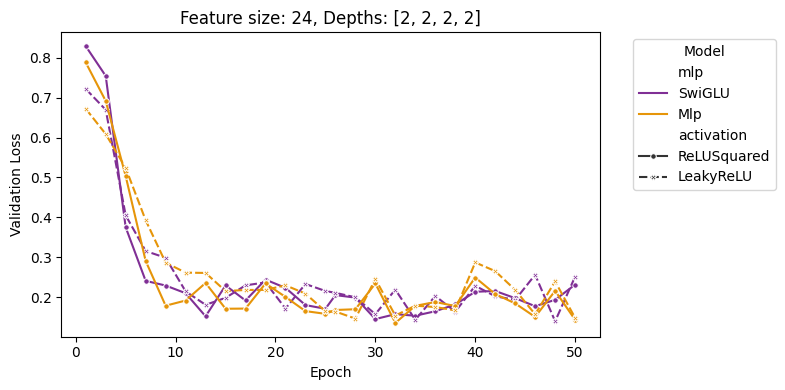

In [169]:
for group, data in val_loss_long.groupby(["feature_size", "depths"], as_index=True):
    # Plot using seaborn
    plt.figure(figsize=(8, 4))
    sns.lineplot(
        data=data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title(f"Feature size: {group[0]}, Depths: {group[1]}")
    # plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train_loss_df = pd.read_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/train_epoch_loss.csv", index_col=0).T.reset_index()
train_loss_fields = train_loss_df["index"].apply(extract_fields)
train_loss_fields["depths"] = train_loss_fields["depths"].apply(lambda x: str(x))
train_loss_plot = train_loss_fields.merge(train_loss_df.drop(columns=["index"]), left_index=True, right_index=True)

# Identify step columns (numeric column names)
id_cols = ["model", "mlp", "activation", "feature_size", "depths", "date", "time", "loss_type"]
step_cols = [col for col in train_loss_plot.columns if col not in id_cols]

# Melt the dataframe from wide to long format
train_loss_long = pd.melt(
    train_loss_plot,
    id_vars=id_cols,
    value_vars=step_cols,
    var_name="step",
    value_name="loss"
)

# Convert step to numeric
train_loss_long["step"] = pd.to_numeric(train_loss_long["step"])
train_loss_long["epoch"] = train_loss_long["step"] // 10
train_loss_long["feature_size"] = train_loss_long["feature_size"].replace("base", "24")
# Remove duplicate rows (if any) by taking unique combinations
train_loss_long = train_loss_long.drop_duplicates(subset=id_cols + ["step"])
train_loss_long

,model,mlp,activation,feature_size,depths,date,time,loss_type,step,loss,epoch
0,SwinUNetR,SwiGLU,ReLUSquared,24,"[1, 1, 1, 1]",12_05,15_31,None,8,0.879886,0
3,SwinUNetR,Mlp,ReLUSquared,24,"[1, 1, 1, 1]",12_05,15_29,None,8,0.915845,0
6,SwinUNetR,SwiGLU,LeakyReLU,24,"[1, 1, 1, 1]",12_05,15_28,None,8,0.842728,0
9,SwinUNetR,Mlp,LeakyReLU,24,"[1, 1, 1, 1]",12_05,15_27,None,8,0.895419,0
12,SwinUNetR,SwiGLU,ReLUSquared,12,"[2, 2, 2, 2]",12_05,15_25,None,8,0.921769,0
...,...,...,...,...,...,...,...,...,...,...,...
1785,SwinUNetR,Mlp,LeakyReLU,12,"[2, 2, 2, 2]",12_05,15_20,None,522,0.406276,52
1788,SwinUNetR,SwiGLU,ReLUSquared,24,"[2, 2, 2, 2]",12_05,15_18,None,522,0.215125,52
1791,SwinUNetR,Mlp,ReLUSquared,24,"[2, 2, 2, 2]",12_05,15_17,None,522,0.197720,52
1794,SwinUNetR,SwiGLU,LeakyReLU,24,"[2, 2, 2, 2]",12_05,15_15,None,522,0.211114,52


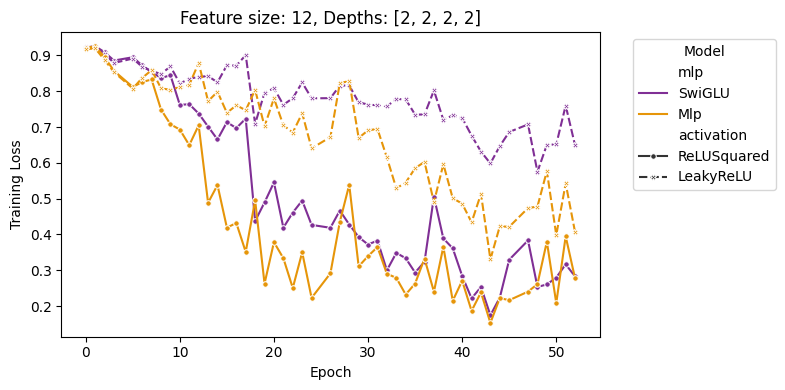

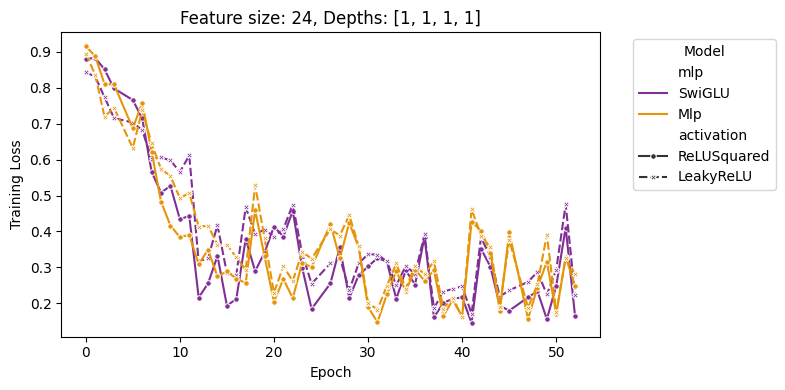

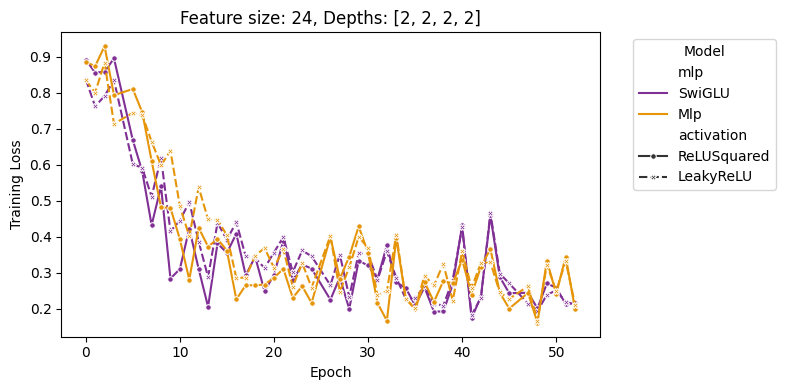

In [174]:
for group, data in train_loss_long.groupby(["feature_size", "depths"], as_index=True):
    # Plot using seaborn
    plt.figure(figsize=(8, 4))
    sns.lineplot(
        data=data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title(f"Feature size: {group[0]}, Depths: {group[1]}")
    # plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

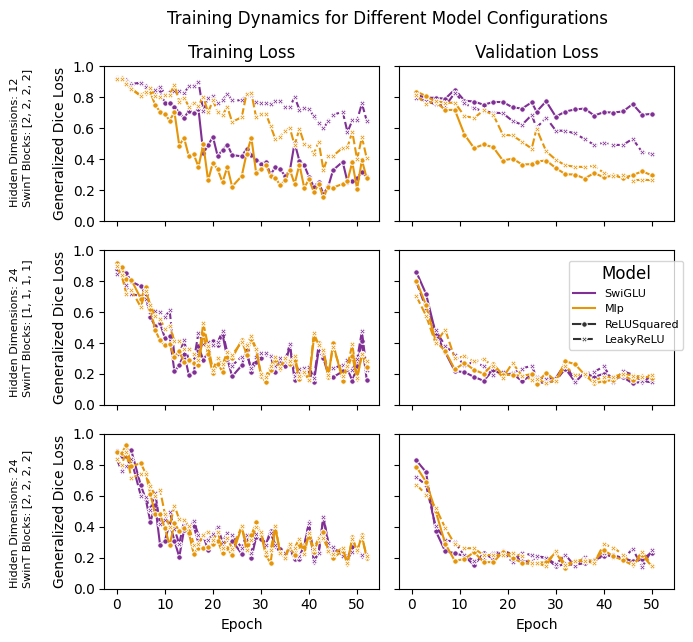

In [319]:
# Make a tall grid plot with each row for a (feature_size, depths) group,
# columns: Training Loss (left), Validation Loss (right).
# Now with shared x and y axes, and fixed y axis from 0 to 1

# Find all groups
groups = list(val_loss_long.groupby(["feature_size", "depths"], as_index=True).groups.keys())
n_groups = len(groups)

# Set up a grid of subplots with shared x and y axes, transposed
fig, axes = plt.subplots(nrows=n_groups, ncols=2, figsize=(7, 7), sharex='all', sharey='all')
if n_groups == 1:
    # Ensure axes is always a 2D array for consistency (in case only one group)
    axes = axes.reshape((1, 2))

collected_legend = None

# Column labels ("Training" and "Validation")
axes[0, 0].set_title("Training Loss", fontsize=12)
axes[0, 1].set_title("Validation Loss", fontsize=12)

for i, group in enumerate(groups):
    # Validation loss data (right column)
    val_data = val_loss_long[(val_loss_long["feature_size"] == group[0]) & (val_loss_long["depths"] == group[1])]
    # Training loss data (left column)
    train_data = train_loss_long[(train_loss_long["feature_size"] == group[0]) & (train_loss_long["depths"] == group[1])]

    # Training Loss Plot (left column)
    ax1 = axes[i, 0]
    lines_train = sns.lineplot(
        data=train_data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap",
        ax=ax1
    )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Generalized Dice Loss")
    ax1.set_ylim(0, 1)  # Fix y-axis from 0 to 1
    if i != 0:
        ax1.set_title("")  # Remove old title

    # Row label (to the left of the row), using fig.text at vertical center of subplot
    row_label = f"Hidden Dimensions: {group[0]}\nSwinT Blocks: {group[1]}"
    ax_pos = ax1.get_position()
    fig.text(
        0.03, ax_pos.y0 + 0.5*(ax_pos.y1 - ax_pos.y0), row_label,
        va='center', ha='left', rotation=90, fontsize=8
    )

    # Collect the legend from the first plot
    if i == 0 and ax1.get_legend():
        handles, labels = ax1.get_legend_handles_labels()
        # Filter legend for unique & non-empty labels except for the automatic hue/style headers
        filtered = [(h, l) for h, l in zip(handles, labels) if l not in ["mlp", "activation"] and l.strip() != ""]
        if filtered:
            line_handles, line_labels = zip(*filtered)
            collected_legend = (line_handles, line_labels)
    if ax1.get_legend():
        ax1.get_legend().remove()

    # Validation Loss Plot (right column)
    ax2 = axes[i, 1]
    lines_val = sns.lineplot(
        data=val_data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap",
        ax=ax2
    )
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Generalized Dice Loss")
    ax2.set_ylim(0, 1)  # Fix y-axis from 0 to 1
    if i != 0:
        ax2.set_title("")
    if ax2.get_legend():
        ax2.get_legend().remove()

# Add the combined legend to the right of the figure (only one legend for all subplots)
if collected_legend:
    # Place legend in upper right outside plot area
    fig.legend(
        collected_legend[0], collected_legend[1],
        title="Model",
        loc='upper right',
        bbox_to_anchor=(1, 0.6),
        ncol=1,
        fontsize=8,
        title_fontsize=12,
        borderaxespad=0.5,
        frameon=True
    )

plt.suptitle("Training Dynamics for Different Model Configurations", fontsize=12, y=0.95, x=0.57)

plt.tight_layout(rect=(0.07, 0.04, 1, 0.97))
plt.savefig("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/loss_plot_tall.png", dpi=400, bbox_inches='tight')

plt.show()


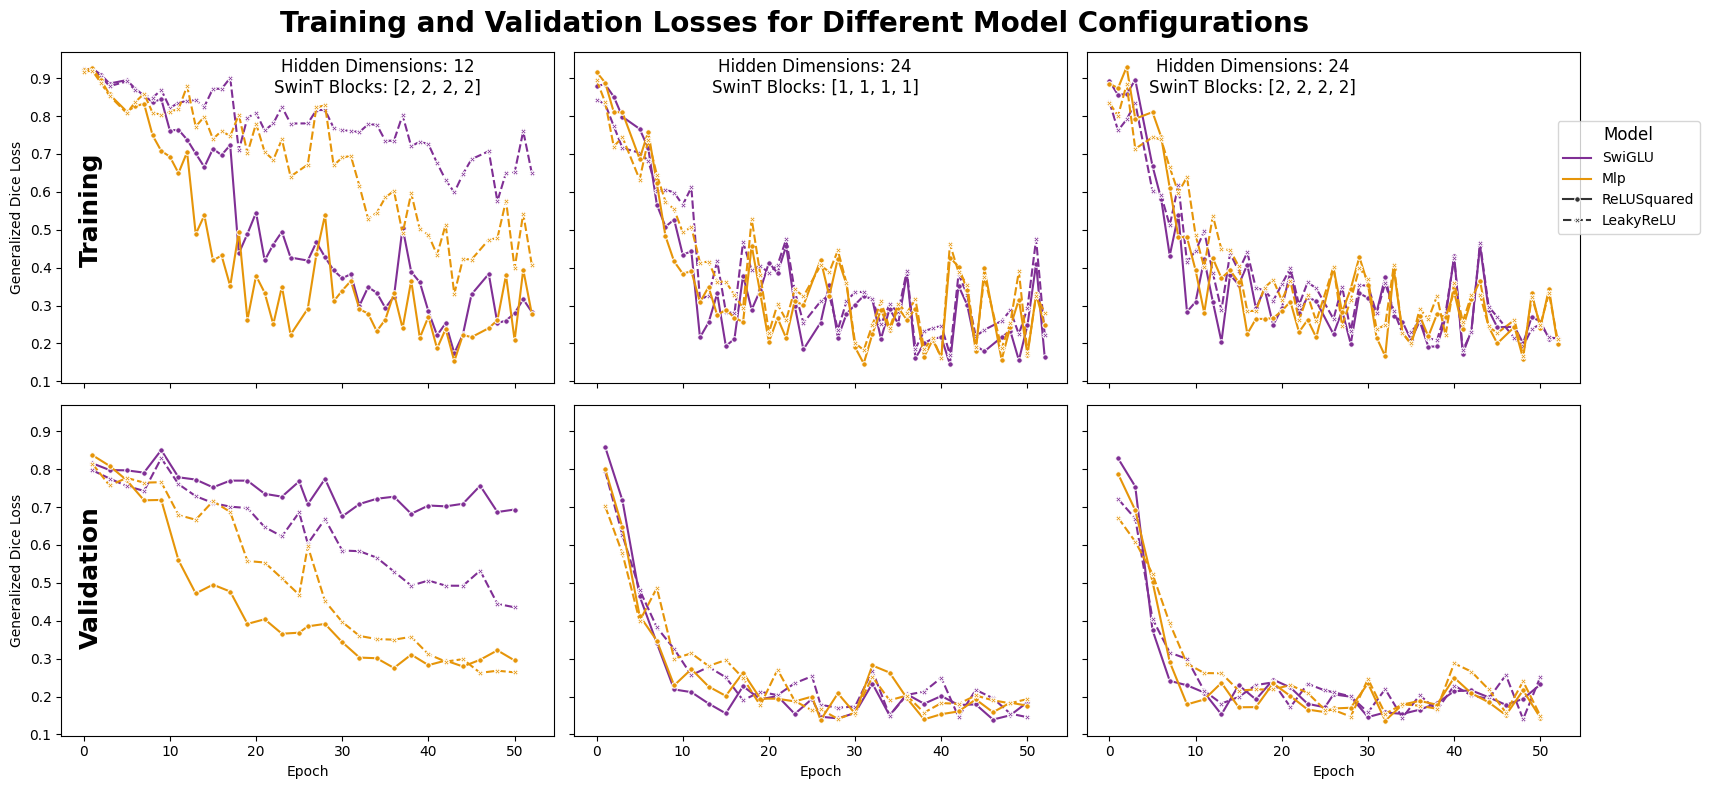

In [282]:
# Make a wide grid plot with each column for a (feature_size, depths) group,
# rows: Training Loss (top), Validation Loss (bottom).
# Now with shared x and y axes

# Find all groups
groups = list(val_loss_long.groupby(["feature_size", "depths"], as_index=True).groups.keys())
n_groups = len(groups)

# Set up a grid of subplots with shared x and y axes
fig, axes = plt.subplots(nrows=2, ncols=n_groups, figsize=(16, 8), sharex='all', sharey='all')
if n_groups == 1:
    # Ensure axes is always a 2D array for consistency (in case only one group)
    axes = axes.reshape((2, 1))

collected_legend = None

# Row labels ("Training" and "Validation")
fig.text(0.06, 0.73, "Training", ha="center", va="center", fontsize=18, weight='bold', rotation=90)
fig.text(0.06, 0.27, "Validation", ha="center", va="center", fontsize=18, weight='bold', rotation=90)

for j, group in enumerate(groups):
    # Validation loss data (bottom row)
    val_data = val_loss_long[(val_loss_long["feature_size"] == group[0]) & (val_loss_long["depths"] == group[1])]
    # Training loss data (top row)
    train_data = train_loss_long[(train_loss_long["feature_size"] == group[0]) & (train_loss_long["depths"] == group[1])]

    # Training Loss Plot (top row)
    ax1 = axes[0, j]
    lines_train = sns.lineplot(
        data=train_data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap",
        ax=ax1
    )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Generalized Dice Loss")
    ax1.set_title("")  # Remove old title

    # Collect the legend from the first plot
    if j == 0 and ax1.get_legend():
        handles, labels = ax1.get_legend_handles_labels()
        # Filter legend for unique & non-empty labels except for the automatic hue/style headers
        filtered = [(h, l) for h, l in zip(handles, labels) if l not in ["mlp", "activation"] and l.strip() != ""]
        if filtered:
            line_handles, line_labels = zip(*filtered)
            collected_legend = (line_handles, line_labels)
    if ax1.get_legend():
        ax1.get_legend().remove()

    # Column label (above each column)
    col_label = f"Hidden Dimensions: {group[0]}\nSwinT Blocks: {group[1]}"
    # Place the label above the column using fig.text
    ax_pos = ax1.get_position()
    fig.text(ax_pos.x0 + 0.5 * (ax_pos.x1 - ax_pos.x0), 0.92, col_label, va='top', ha='center', rotation=0, fontsize=12)

    # Validation Loss Plot (bottom row)
    ax2 = axes[1, j]
    lines_val = sns.lineplot(
        data=val_data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap",
        ax=ax2
    )
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Generalized Dice Loss")
    ax2.set_title("")
    if ax2.get_legend():
        ax2.get_legend().remove()

# Add the combined legend to the right of the figure (only one legend for all subplots)
if collected_legend:
    fig.legend(
        collected_legend[0], collected_legend[1],
        title="Model", 
        loc='upper right', 
        bbox_to_anchor=(1.07, 0.85),
        ncol=1,
        fontsize='medium',
        title_fontsize='large',
        borderaxespad=0.5,
        frameon=True
    )

plt.suptitle("Training and Validation Losses for Different Model Configurations", fontsize=20, weight='bold')

plt.tight_layout()
plt.savefig("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/loss_plot_wide.png", dpi=400, bbox_inches='tight')

plt.show()



In [248]:
ave_val_loss = val_loss_long[val_loss_long["epoch"] > 40].groupby(["feature_size", "depths","mlp", "activation"])["loss"].describe()[["mean", "std"]].round(3)
ave_val_loss.columns = ["Average Validation Loss", "Std. Dev of Validation Loss"]
ave_val_loss.reset_index().to_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/ave_val_loss.csv")
ave_val_loss

Average Validation Loss  \
feature_size depths       mlp    activation                             
12           [2, 2, 2, 2] Mlp    LeakyReLU                      0.277   
                                 ReLUSquared                    0.298   
                          SwiGLU LeakyReLU                      0.479   
                                 ReLUSquared                    0.709   
24           [1, 1, 1, 1] Mlp    LeakyReLU                      0.190   
                                 ReLUSquared                    0.174   
                          SwiGLU LeakyReLU                      0.172   
                                 ReLUSquared                    0.166   
             [2, 2, 2, 2] Mlp    LeakyReLU                      0.206   
                                 ReLUSquared                    0.181   
                          SwiGLU LeakyReLU                      0.209   
                                 ReLUSquared                    0.204   

                                              Std. Dev of Validation Loss  
feature_size depths       mlp    activation                                
12           [2, 2, 2, 2] Mlp    LeakyReLU                          0.017  
                                 ReLUSquared                        0.015  
                          SwiGLU LeakyReLU                          0.040  
                                 ReLUSquared                        0.027  
24           [1, 1, 1, 1] Mlp    LeakyReLU                          0.009  
                                 ReLUSquared                        0.015  
                          SwiGLU LeakyReLU                          0.033  
                                 ReLUSquared                        0.020  
             [2, 2, 2, 2] Mlp    LeakyReLU                          0.051  
                                 ReLUSquared                        0.033  
                          SwiGLU LeakyReLU                          0.048  
                                 ReLUSquared                        0.021

In [249]:
# Get the best epoch for each model
best_epochs = val_loss_long.set_index("epoch").groupby(["feature_size", "depths", "mlp", "activation"])["loss"].idxmin()
best_epochs.name = "Best Epoch"
best_epochs.reset_index().to_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/best_epochs.csv")
best_epochs

feature_size  depths        mlp     activation 
12            [2, 2, 2, 2]  Mlp     LeakyReLU      46
                                    ReLUSquared    36
                            SwiGLU  LeakyReLU      50
                                    ReLUSquared    30
24            [1, 1, 1, 1]  Mlp     LeakyReLU      28
                                    ReLUSquared    26
                            SwiGLU  LeakyReLU      50
                                    ReLUSquared    46
              [2, 2, 2, 2]  Mlp     LeakyReLU      28
                                    ReLUSquared    32
                            SwiGLU  LeakyReLU      48
                                    ReLUSquared    30
Name: Best Epoch, dtype: int64

In [250]:
merged_df = ave_val_loss.merge(best_epochs, left_index=True, right_index=True)
merged_df

Average Validation Loss  \
feature_size depths       mlp    activation                             
12           [2, 2, 2, 2] Mlp    LeakyReLU                      0.277   
                                 ReLUSquared                    0.298   
                          SwiGLU LeakyReLU                      0.479   
                                 ReLUSquared                    0.709   
24           [1, 1, 1, 1] Mlp    LeakyReLU                      0.190   
                                 ReLUSquared                    0.174   
                          SwiGLU LeakyReLU                      0.172   
                                 ReLUSquared                    0.166   
             [2, 2, 2, 2] Mlp    LeakyReLU                      0.206   
                                 ReLUSquared                    0.181   
                          SwiGLU LeakyReLU                      0.209   
                                 ReLUSquared                    0.204   

                                              Std. Dev of Validation Loss  \
feature_size depths       mlp    activation                                 
12           [2, 2, 2, 2] Mlp    LeakyReLU                          0.017   
                                 ReLUSquared                        0.015   
                          SwiGLU LeakyReLU                          0.040   
                                 ReLUSquared                        0.027   
24           [1, 1, 1, 1] Mlp    LeakyReLU                          0.009   
                                 ReLUSquared                        0.015   
                          SwiGLU LeakyReLU                          0.033   
                                 ReLUSquared                        0.020   
             [2, 2, 2, 2] Mlp    LeakyReLU                          0.051   
                                 ReLUSquared                        0.033   
                          SwiGLU LeakyReLU                          0.048   
                                 ReLUSquared                        0.021   

                                              Best Epoch  
feature_size depths       mlp    activation               
12           [2, 2, 2, 2] Mlp    LeakyReLU            46  
                                 ReLUSquared          36  
                          SwiGLU LeakyReLU            50  
                                 ReLUSquared          30  
24           [1, 1, 1, 1] Mlp    LeakyReLU            28  
                                 ReLUSquared          26  
                          SwiGLU LeakyReLU            50  
                                 ReLUSquared          46  
             [2, 2, 2, 2] Mlp    LeakyReLU            28  
                                 ReLUSquared          32  
                          SwiGLU LeakyReLU            48  
                                 ReLUSquared          30

In [251]:
merged_df.reset_index().to_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/best_stats.csv")

In [278]:
styled_table = merged_df.style.background_gradient(
    cmap=sns.light_palette("seagreen", as_cmap=True), # Use a nice Seaborn palette
    subset=["Average Validation Loss"] # Specify which column to color
)



In [279]:
styled_table

In [1]:
from pathlib import Path
import pandas as pd

base_dir = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/train_swin_unetr_cellseg3d_mesoSPIM")
models = ["SwinUNetR_Mlp_LeakyReLU", "SwinUNetR_SwiGLU_LeakyReLU", "SwinUNetR_Mlp_ReLUSquared", "SwinUNetR_SwiGLU_ReLUSquared"]
model_configs = ["base_model", "feature_size_12", "model_depths_1_1_1_1"]
all_val_data = []
all_train_data = []
for model_config in model_configs:
    noko_dir = base_dir / model_config / "noko_runs"
    paths = list(noko_dir.iterdir())
    paths.sort()
    for i, model in enumerate(models):
        train_data_path = paths[i] / "Training" / "Epoch loss.csv"
        train_data = pd.read_csv(train_data_path)
        train_data["model"] = model
        train_data["model_config"] = model_config
        val_data_path = paths[i] / "Validation" / "Mean Loss (epoch).csv"
        val_data = pd.read_csv(val_data_path)
        val_data["model"] = model
        val_data["model_config"] = model_config
        all_val_data.append(val_data)
        all_train_data.append(train_data)
        
feature_size_map = {
    "base_model": 24,
    "feature_size_12": 12,
    "model_depths_1_1_1_1": 24
}

depths_map = {
    "base_model": 2,
    "feature_size_12": 2,
    "model_depths_1_1_1_1": 1
}

all_train_data = pd.concat(all_train_data)
all_train_data["model"].str.split("_", expand=True)
all_train_data["mlp"] = all_train_data["model"].str.split("_", expand=True)[1]
all_train_data["activation"] = all_train_data["model"].str.split("_", expand=True)[2]
all_train_data.rename(columns={"$step": "epoch"}, inplace=True)
all_train_data["feature_size"] = all_train_data["model_config"].map(feature_size_map)
all_train_data["depths"] = all_train_data["model_config"].map(depths_map)

all_val_data = pd.concat(all_val_data)
all_val_data["model"].str.split("_", expand=True)
all_val_data["mlp"] = all_val_data["model"].str.split("_", expand=True)[1]
all_val_data["activation"] = all_val_data["model"].str.split("_", expand=True)[2]
all_val_data.rename(columns={"$step": "epoch"}, inplace=True)
all_val_data["feature_size"] = all_val_data["model_config"].map(feature_size_map)
all_val_data["depths"] = all_val_data["model_config"].map(depths_map)


all_train_data.head()
all_val_data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/clusterfs/nvme/segment_3d/tests/supervised_models/train_swin_unetr_cellseg3d_mesoSPIM/base_model/noko_runs'